In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyspark

     |████████████████████████████████| 212.4 MB 61 kB/s 
     |████████████████████████████████| 198 kB 47.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=141fad4a246298b00ee89692a21727d147e0d6952903e36a978b14f200806ad1
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark


In [3]:
import pyspark.sql.functions as sql_func
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics
from pyspark.ml.evaluation import RegressionEvaluator

sc = SparkContext('local')
spark = SparkSession(sc)


In [4]:
data_schema = StructType([
    StructField('userId', IntegerType(), False),
    StructField('movieId', IntegerType(), False),
    StructField('title', StringType(), False),
    StructField('xgbr_rating', FloatType(), False),
    StructField('svr_rating', FloatType(), False),
    StructField('rfr_rating', FloatType(), False)
])
final_stat = spark.read.csv(
    '/content/drive/MyDrive/Colab Notebooks/Hybrid reccomendation using ALS and KNN/datasets/als.csv', header=True, schema=data_schema
).cache()

final_movie = spark.read.csv(
    '/content/drive/MyDrive/Colab Notebooks/Hybrid reccomendation using ALS and KNN/datasets/ml-latest-small/movies.csv', header=True, schema=data_schema
).cache()


ratings = (final_stat.select(
    'userId',
    'movieId',
    'xgbr_rating',
    'svr_rating',
    'rfr_rating'
)).cache()

movie = (final_movie.select(
    'movieId',
    'title'
)).cache()

In [5]:
(training, test) = ratings.randomSplit([0.7, 0.3], seed=42)

In [6]:
def alsmodel(rating):
  als = ALS(
          rank=40,
          maxIter=20, 
          regParam=0.1,
          userCol='userId', 
          itemCol='movieId', 
          ratingCol=rating,
          coldStartStrategy='drop',
          implicitPrefs=False
         )

  model = als.fit(training)
  predictions = model.transform(test)
  evaluator_mae = RegressionEvaluator(metricName='mae', labelCol=rating,
                                predictionCol='prediction')
  
  evaluator_rmse = RegressionEvaluator(metricName='rmse', labelCol=rating,
                                predictionCol='prediction')
  mae = evaluator_mae.evaluate(predictions)
  rmse = evaluator_rmse.evaluate(predictions)
  print(f'MAE (Test) = {mae}')
  print(f'RMSE (Test) = {rmse}')
  return mae,rmse,model


In [7]:
XGBR_ALS = alsmodel("xgbr_rating")
XGBR_ALS[2].recommendForAllUsers(1).show(5)

MAE (Test) = 0.6862593198112659
RMSE (Test) = 0.8835377367561539
+------+------------------+
|userId|   recommendations|
+------+------------------+
|  1580|[{276, 4.4877076}]|
|  4900|[{276, 4.4118614}]|
|  6620| [{53, 4.5332108}]|
|  7340|[{562, 3.9093208}]|
| 32460| [{53, 4.3150163}]|
+------+------------------+
only showing top 5 rows



In [8]:
import pandas as pd
metadata = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Hybrid reccomendation using ALS and KNN/datasets/ml-latest-small/movies_metadata.csv")
links = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Hybrid reccomendation using ALS and KNN/datasets/ml-latest-small/links.csv')
metadata.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [9]:
# Get the Movie on metadata
def get_movie_metadata(movieId):
    metadata['imdb_id'] = metadata['imdb_id'].astype('category')
    imdb_id = links[links['movieId'] == movieId]
    imdb_id = imdb_id.imdbId.values[0]
    if len(str(imdb_id)) == 7:
        movie_rated = metadata[metadata['imdb_id'] == 'tt'+imdb_id.astype(str)]
        df = movie_rated.loc[:,['title', 'overview', 'vote_average', 'release_date']]
        return df.reset_index(drop=True)
    elif len(str(imdb_id)) == 6:
        movie_rated = metadata[metadata['imdb_id'] == 'tt0'+imdb_id.astype(str)]
        df = movie_rated.loc[:,['title', 'overview', 'vote_average', 'release_date']]
        return df.reset_index(drop=True)
    elif len(str(imdb_id)) == 5:
        movie_rated = metadata[metadata['imdb_id'] == 'tt00'+imdb_id.astype(str)]
        df = movie_rated.loc[:,['title', 'overview', 'vote_average', 'release_date']]
        return df.reset_index(drop=True)
    elif len(str(imdb_id)) == 4:
        movie_rated = metadata[metadata['imdb_id'] == 'tt000'+imdb_id.astype(str)]
        df = movie_rated.loc[:,['title', 'overview', 'vote_average', 'release_date']]
        return df.reset_index(drop=True)
    elif len(str(imdb_id)) == 3:
        movie_rated = metadata[metadata['imdb_id'] == 'tt0000'+imdb_id.astype(str)]
        df = movie_rated.loc[:,['title', 'overview', 'vote_average', 'release_date']]
        return df.reset_index(drop=True)
    elif len(str(imdb_id)) == 2:
        movie_rated = metadata[metadata['imdb_id'] == 'tt00000'+imdb_id.astype(str)]
        df = movie_rated.loc[:,['title', 'overview', 'vote_average', 'release_date']]
        return df.reset_index(drop=True)
    elif len(str(imdb_id)) == 1:
        movie_rated = metadata[metadata['imdb_id'] == 'tt000000'+imdb_id.astype(str)]
        df = movie_rated.loc[:,['title', 'overview', 'vote_average', 'release_date']]
        return df.reset_index(drop=True)
    else:
        pass

In [10]:
get_movie_metadata(544)

,title,overview,vote_average,release_date
0,Striking Distance,"Coming from a police family, Tom Hardy ends up...",5.4,1993-09-17


In [11]:
RFR_ALS = alsmodel("rfr_rating")

MAE (Test) = 0.11022121862182353
RMSE (Test) = 0.11194305868326558


In [12]:
SVR_ALS = alsmodel("svr_rating")

MAE (Test) = 0.47046011964274553
RMSE (Test) = 0.605699014995282


In [13]:
RFR_ALS[2].recommendForAllUsers(1).show(5)

+------+----------------+
|userId| recommendations|
+------+----------------+
|  1580|[{6, 3.5009613}]|
|  4900| [{6, 3.242179}]|
|  6620|[{6, 3.1297016}]|
|  7340|[{6, 3.0841198}]|
| 32460| [{6, 3.131553}]|
+------+----------------+
only showing top 5 rows



In [14]:
SVR_ALS[2].recommendForAllUsers(1).show(5)

+------+------------------+
|userId|   recommendations|
+------+------------------+
|  1580|[{543, 4.2569475}]|
|  4900|[{276, 4.3327365}]|
|  6620| [{53, 4.1830697}]|
|  7340| [{452, 3.553219}]|
| 32460| [{53, 4.4835606}]|
+------+------------------+
only showing top 5 rows



In [15]:
SVR_ALS[2].recommendForAllItems(1).show(5)

+-------+--------------------+
|movieId|     recommendations|
+-------+--------------------+
|    471| [{5490, 4.5804896}]|
|    463|[{179135, 4.66333...|
|    496|[{33649, 4.4033318}]|
|    148|  [{6201, 4.369875}]|
|    540|[{67618, 5.0759087}]|
+-------+--------------------+
only showing top 5 rows



In [16]:
XGBR_ALS[2].recommendForAllItems(1).show(5)

+-------+--------------------+
|movieId|     recommendations|
+-------+--------------------+
|    471|  [{527, 4.6935472}]|
|    463|[{78836, 4.4753594}]|
|    496|  [{4973, 4.415477}]|
|    148|[{160718, 3.85037...|
|    540|  [{3200, 4.815179}]|
+-------+--------------------+
only showing top 5 rows



In [17]:
RFR_ALS[2].recommendForAllItems(1).show(5)

+-------+-----------------+
|movieId|  recommendations|
+-------+-----------------+
|    471|[{38, 3.4970255}]|
|    463|[{38, 3.4941995}]|
|    496|[{38, 3.4827437}]|
|    148|[{38, 3.5444329}]|
|    540|[{38, 3.4736142}]|
+-------+-----------------+
only showing top 5 rows



In [18]:
MLA = {
     'ALS + XGB Regrresor' : XGBR_ALS,
     'ALS + Random Forrest Regrresor' : RFR_ALS,
     'ALS + SV Regrresor' : SVR_ALS,  
}

In [19]:
columns = []
compare = pd.DataFrame(columns = columns)
row_index = 0
for name,alg in MLA.items():
    MLA_name = name
    compare.loc[row_index,'Name'] = MLA_name
    compare.loc[row_index, 'MAE'] = alg[0]
    compare.loc[row_index, 'RMSE'] = alg[1]
    row_index+=1
    
compare.sort_values(by = ['RMSE'], ascending = True, inplace = True)    
compare

,Name,MAE,RMSE
1,ALS + Random Forrest Regrresor,0.110221,0.111943
2,ALS + SV Regrresor,0.470460,0.605699
0,ALS + XGB Regrresor,0.686259,0.883538


In [20]:

#plot comaparison 
def compare_plots(y_value):
  plt.subplots(figsize=(11,8))
  sn.barplot(x="Name", y=y_value ,data=compare,palette='hot',edgecolor=sn.color_palette('cool',7))
  plt.xticks(rotation=45)
  plt.title('Comparing techniques with '+y_value+'.')
  plt.show()
  return plt

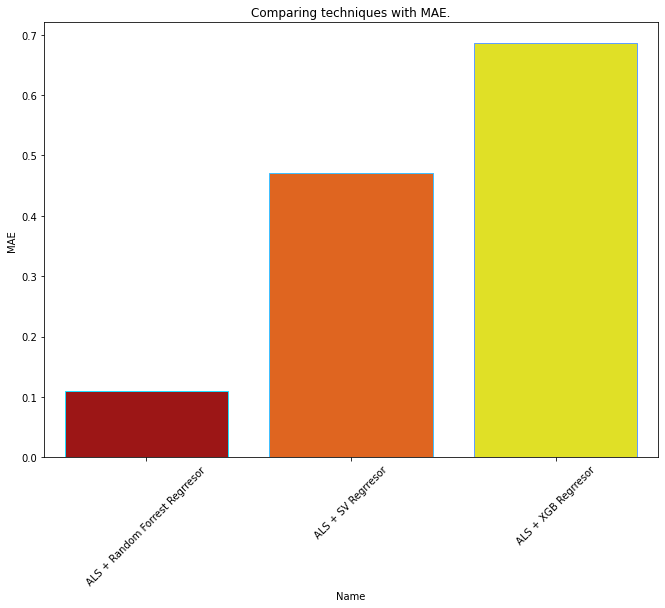

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [21]:
import matplotlib.pyplot as plt
import seaborn as sn
compare_plots("MAE")

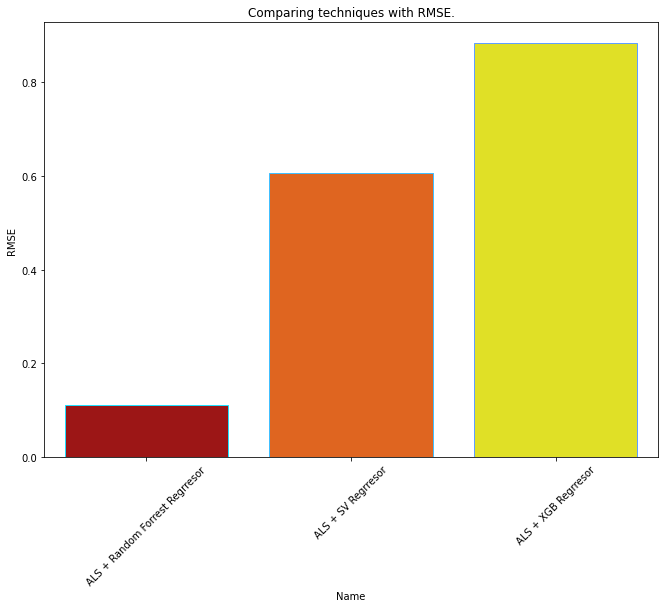

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [22]:
compare_plots("RMSE")

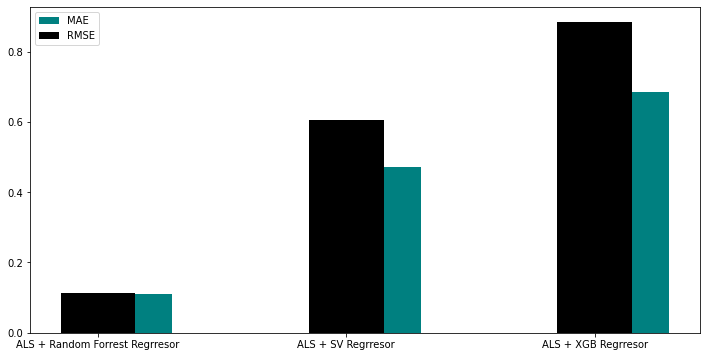

In [23]:
plt.figure(figsize=(12, 6))

plt.bar(x=compare.Name, height=compare.MAE, label="MAE", align="edge", width=0.3, color='teal')
plt.bar(x=compare.Name, height=compare.RMSE, label="RMSE", width=0.3, color='black')
plt.legend()
plt.xticks(rotation=0)
plt.show()